# Cleaning and Imputing the Data
Because of the missing data from the SQF data, this notebook attempts to clean and impute missing values. The goal will to have datasets that are just listwise deleted and imputed to compare and analyze the impact of imputing the missing data.

## Packages

In [1]:
#!pip install impyute
#! pip install missingno
# !pip install xlrd

# Set Up
import pandas as pd
import numpy as np

# Visualiztion
import seaborn as sns
import missingno as msno

# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)


## Importing Data
Becuase there are 83 features and over 13000 records, I'm going to break this dataset into smaller dataframes, clean seperately, then re-aggregate via the unique identifier key 'STOP_ID_ANONY'.

* location: describes the location of the SQF
* officer: describes the title, appearance, and behaviors of the officer
* suspect: describes the physical characteristics of the suspect
* sentiment: contains descriptions of the suspect from the perspective of the officer, useful for sentiment analysis

In [2]:
# A Hard copy just incase 
#raw = pd.read_excel('../data/sqf-2019.xlsx')

#Load directly from the source site
url2019 = 'https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2019.xlsx'
raw = pd.read_excel(url2019)

In [3]:
# Breaking original dataframe into subsets based on characteristics

location = raw[['STOP_ID_ANONY', 'STOP_FRISK_DATE', 'STOP_FRISK_TIME',
                'YEAR2', 'MONTH2', 'DAY2','LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 
                'JURISDICTION_DESCRIPTION', 'STOP_LOCATION_PRECINCT', 'STOP_LOCATION_SECTOR_CODE'
                ,'STOP_LOCATION_APARTMENT','STOP_LOCATION_FULL_ADDRESS','STOP_LOCATION_STREET_NAME'
                ,'STOP_LOCATION_X','STOP_LOCATION_Y','STOP_LOCATION_ZIP_CODE',
                'STOP_LOCATION_PATROL_BORO_NAME','STOP_LOCATION_BORO_NAME']]


suspect = raw[['STOP_ID_ANONY','SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_ARRESTED_FLAG',
              'FRISKED_FLAG','SEARCHED_FLAG','ASK_FOR_CONSENT_FLG'
               ,'CONSENT_GIVEN_FLG','OTHER_CONTRABAND_FLAG','FIREARM_FLAG'
               ,'KNIFE_CUTTER_FLAG','OTHER_WEAPON_FLAG','WEAPON_FOUND_FLAG'
               ,'SUSPECTS_ACTIONS_CASING_FLAG','SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG'
               ,'SUSPECTS_ACTIONS_DECRIPTION_FLAG','SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG'
               ,'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG','SUSPECTS_ACTIONS_LOOKOUT_FLAG'
               ,'SUSPECTS_ACTIONS_OTHER_FLAG','SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG'
               ,'SUSPECT_REPORTED_AGE','SUSPECT_SEX','SUSPECT_RACE_DESCRIPTION'
               ,'SUSPECT_HEIGHT','SUSPECT_WEIGHT','SUSPECT_BODY_BUILD_TYPE'
               ,'SUSPECT_EYE_COLOR','SUSPECT_HAIR_COLOR']]


officer = raw[['STOP_ID_ANONY', 'ISSUING_OFFICER_RANK', 'ISSUING_OFFICER_COMMAND_CODE',
              'SUPERVISING_OFFICER_RANK', 'SUPERVISING_OFFICER_COMMAND_CODE',
              'OFFICER_IN_UNIFORM_FLAG', 'ID_CARD_IDENTIFIES_OFFICER_FLAG',
              'SHIELD_IDENTIFIES_OFFICER_FLAG', 'VERBAL_IDENTIFIES_OFFICER_FLAG']]
 
# Will be cleaned and saved for later if sentiment analysis is deemed neccessary
# sentiment = raw[['STOP_ID_ANONY', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 
#                  'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION',
#                  'DEMEANOR_OF_PERSON_STOPPED', 'SUSPECT_OTHER_DESCRIPTION']]


### The key metric of this notebook will be looking at how many rows had to be dropped.

In [4]:
summary_table = pd.DataFrame(columns = ['suspect', 'officer','location'], 
                             index = ['Original Number of Rows', 'Post-Clean', 'Difference/Rows Dropped'])
summary_table.iloc[0,:] = [len(suspect), len(officer), len(location)]
summary_table

,suspect,officer,location
Original Number of Rows,13459,13459,13459
Post-Clean,NaN,NaN,NaN
Difference/Rows Dropped,NaN,NaN,NaN


## 1. subject

#### Fix remaining clerical errors

In [5]:
# Converting the Y/N symbols to 1/0 accordingly
suspect.replace({"Y": 1, "N" : 0}, inplace = True)

#Turning clerical errors such as typing "(" and "(null)" into a NaN 
suspect.replace({'(null)': np.nan, "(": np.nan, '': np.nan, ' ': np.nan} ,inplace = True)

#Filling in any remaining missing values with na for visualization
suspect.fillna(np.nan, inplace = True)

# Turning the SEX colunmn in to a Dummy Variable for Females
suspect['FEMALE'] = [1 if i =='FEMALE' else 0 for i in suspect['SUSPECT_SEX']]
suspect = suspect.drop('SUSPECT_SEX', axis = 1)

/Users/winsontruong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/Users/winsontruong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/winsontruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

(<matplotlib.axes._subplots.AxesSubplot at 0x126f096a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126e5df60>)

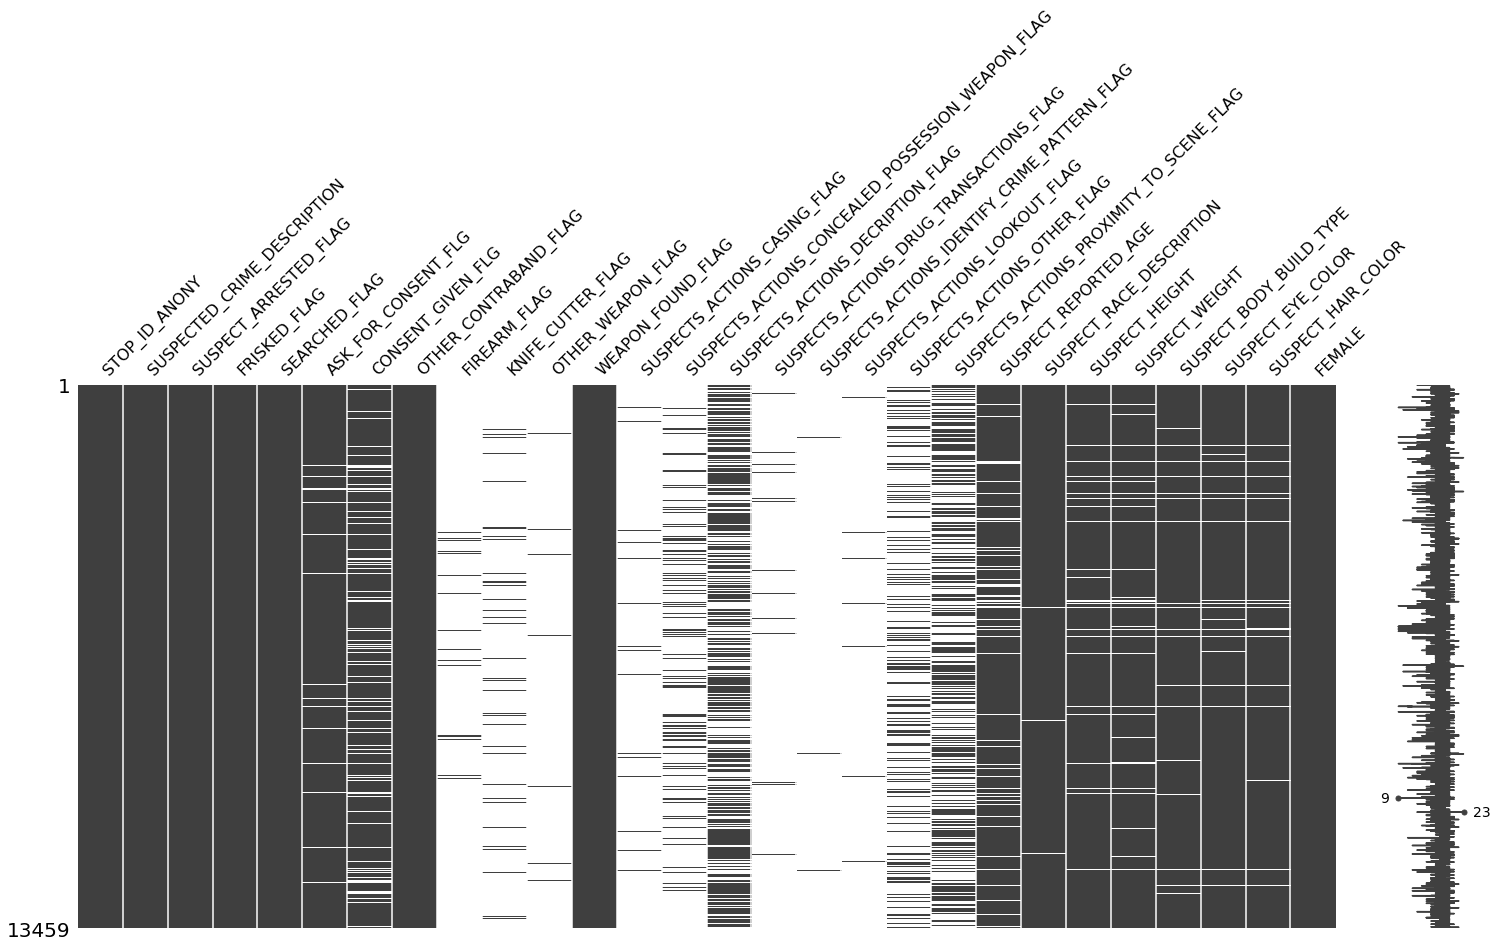

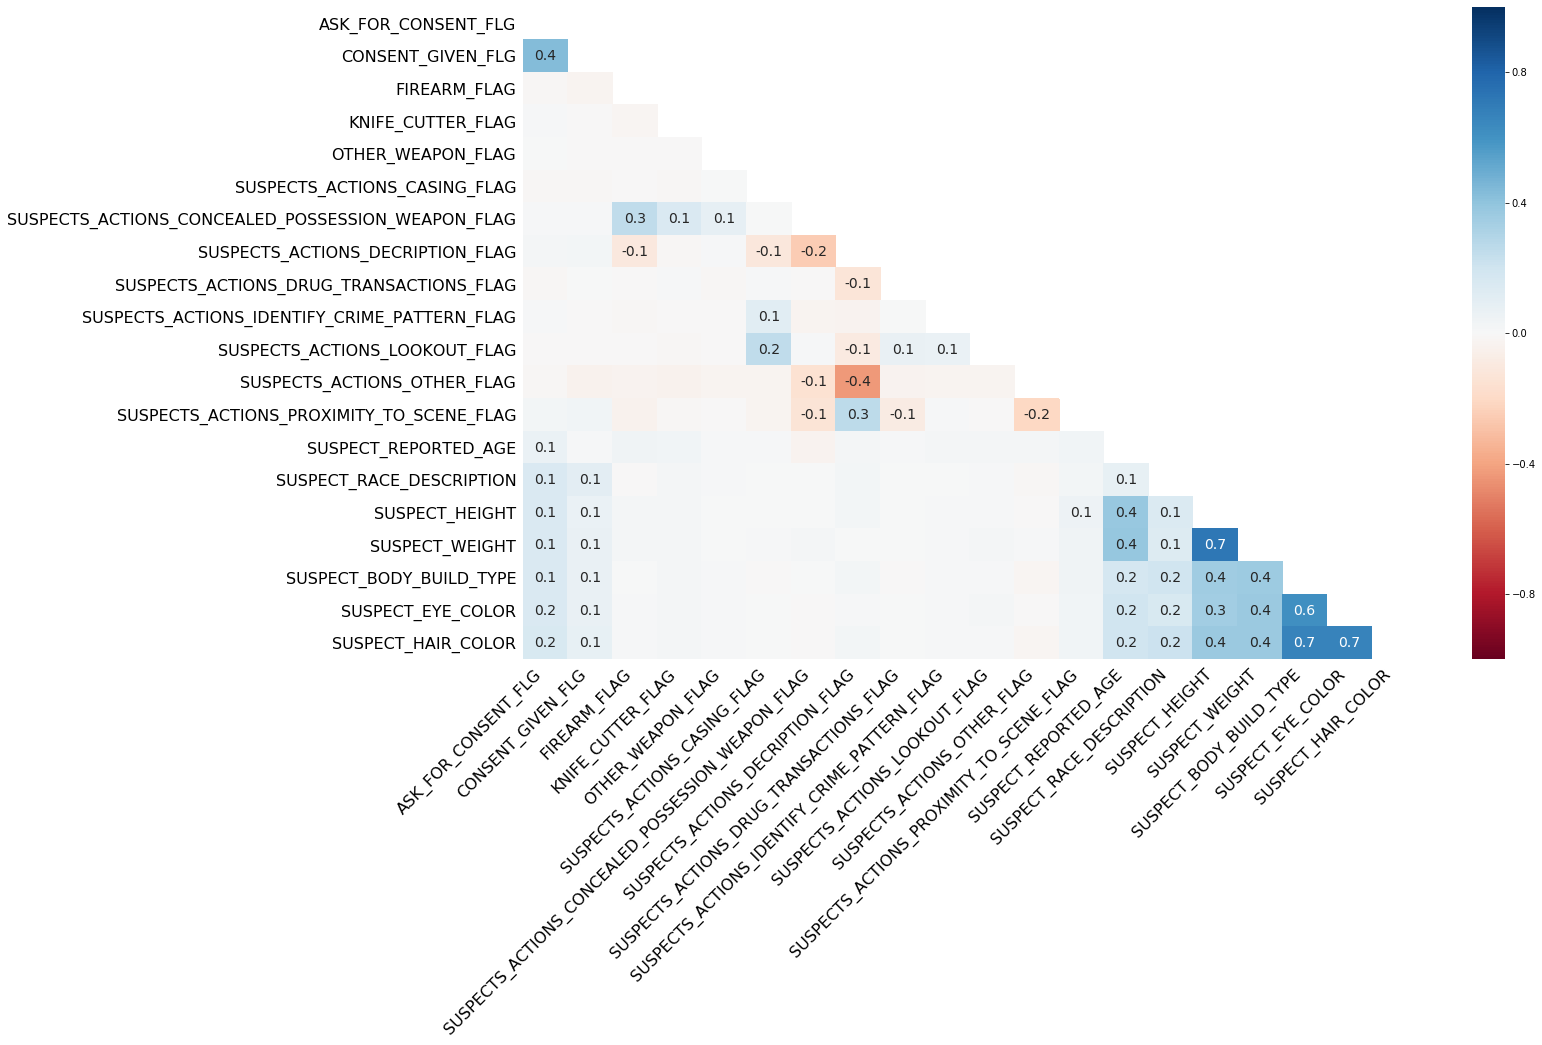

In [6]:
# Visualizes missing data
msno.matrix(suspect), msno.heatmap(suspect)

### From first glance, it seems as many of the dummy variables/flags having missing data. 
* Firearm, Knifecutter, and Otherweapons is poorly specified but "OTHER_WEAPON_FOUND" is well specified
* Details regarding the suspects actions are vague in terms of the flags but the "DESCRIPTION" is somewhat well defined

### Considerations for how to Impute my Missing Data
I want to preserve the dummy variable relationship with the other well-defined features and mean imputation isn't ideal here because then I would have to draw a linear boundary for the dummy variables. Also, this whole project is aimed at understanding and decomposing the bias the officers have against POC so I want something that can maintain that relationship. Overall a **multivariate feature implmentation** such as MICE or K-Nearest Nieghbors seems to meet my objective

### Let's begin with imputing the categorical features.

For the mostly defined features (>80%) such as demographics (eye color, hair color, etc.), I'm going to use the mode as the imputed value as I don't think it will harm the bias of the data that much.

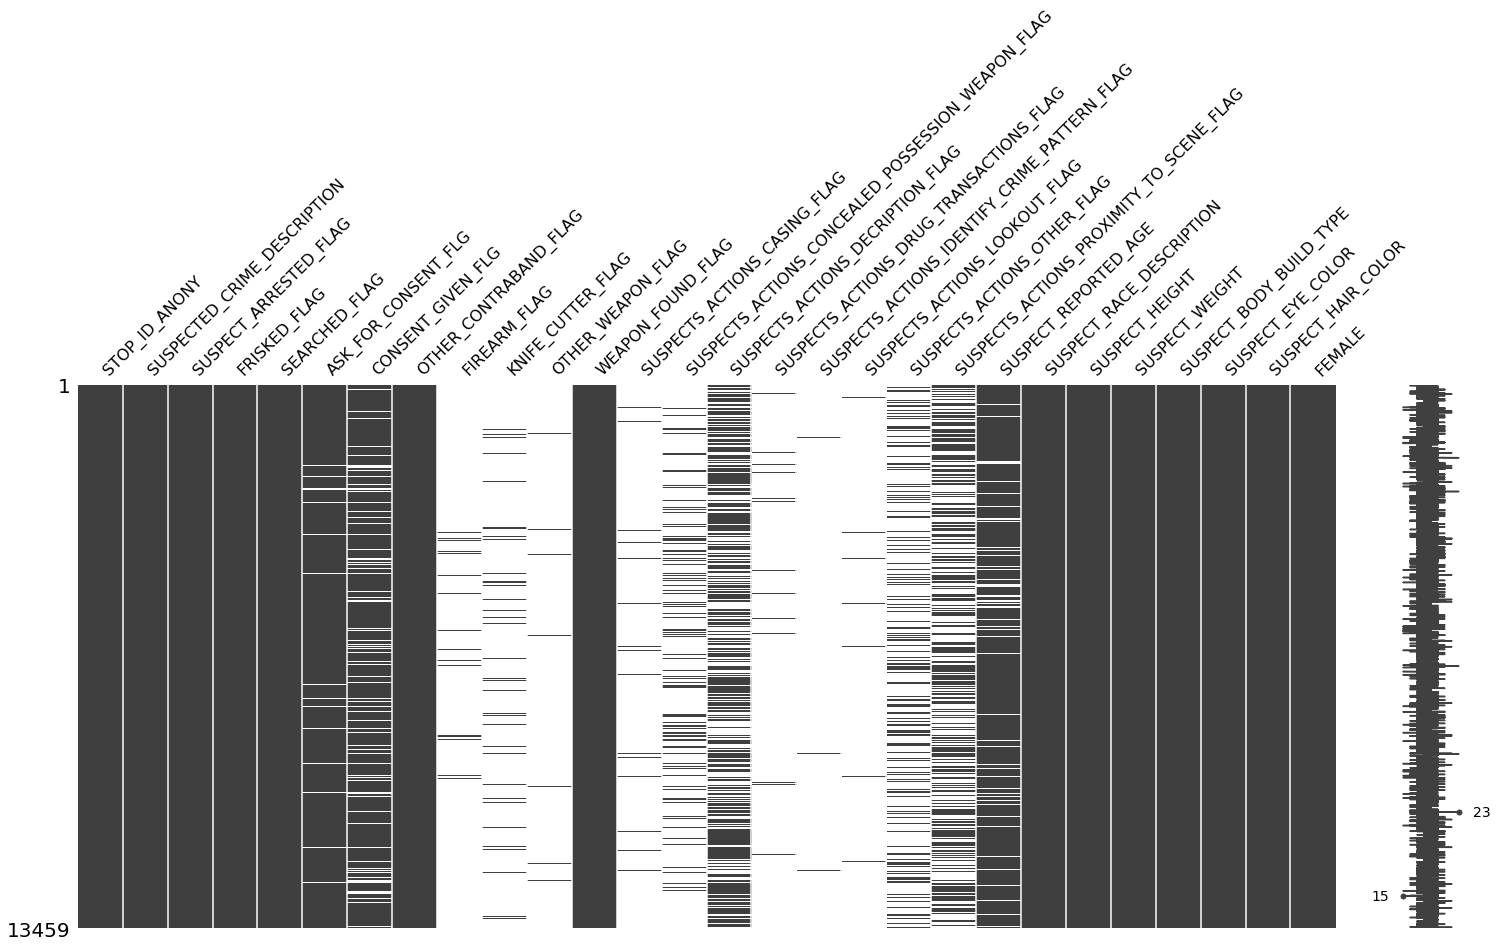

In [7]:
#!pip install sklearn_pandas
from sklearn_pandas import CategoricalImputer

def categorical_impute(df, feature_list):
    imputer = CategoricalImputer()
    for each_feature in feature_list:
        df[each_feature] = imputer.fit_transform(df[each_feature])

categorical_impute(suspect, ['SUSPECT_RACE_DESCRIPTION', 'SUSPECT_HEIGHT',
                             'SUSPECT_WEIGHT', 'SUSPECT_BODY_BUILD_TYPE', 
                             'SUSPECT_EYE_COLOR','SUSPECT_HAIR_COLOR'])

msno.matrix(suspect)

In order to maintain the relational integrity between my variables during imputation, I'm going to now break down the categorical features into dummies so they I have a fully numeric matrix in which I can run things such  as KNN and MICE, then reaggregate.

In [8]:
suspect = pd.get_dummies(suspect, columns = ['SUSPECT_RACE_DESCRIPTION', 'SUSPECT_HAIR_COLOR', 
                                   'SUSPECT_BODY_BUILD_TYPE','SUSPECT_EYE_COLOR',
                                  'SUSPECTED_CRIME_DESCRIPTION'])
suspect.head()

,STOP_ID_ANONY,SUSPECT_ARRESTED_FLAG,FRISKED_FLAG,SEARCHED_FLAG,ASK_FOR_CONSENT_FLG,CONSENT_GIVEN_FLG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,...,SUSPECTED_CRIME_DESCRIPTION_MURDER,SUSPECTED_CRIME_DESCRIPTION_OTHER,SUSPECTED_CRIME_DESCRIPTION_PETIT LARCENY,SUSPECTED_CRIME_DESCRIPTION_PROSTITUTION,SUSPECTED_CRIME_DESCRIPTION_RAPE,SUSPECTED_CRIME_DESCRIPTION_RECKLESS ENDANGERMENT,SUSPECTED_CRIME_DESCRIPTION_ROBBERY,SUSPECTED_CRIME_DESCRIPTION_TERRORISM,SUSPECTED_CRIME_DESCRIPTION_THEFT OF SERVICES,SUSPECTED_CRIME_DESCRIPTION_UNAUTHORIZED USE OF A VEHICLE
0,1,0,1,0,1.0,1.0,0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,2,1,0,1,0.0,0.0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0.0,NaN,0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,0.0,0.0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
4,5,1,1,0,0.0,0.0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


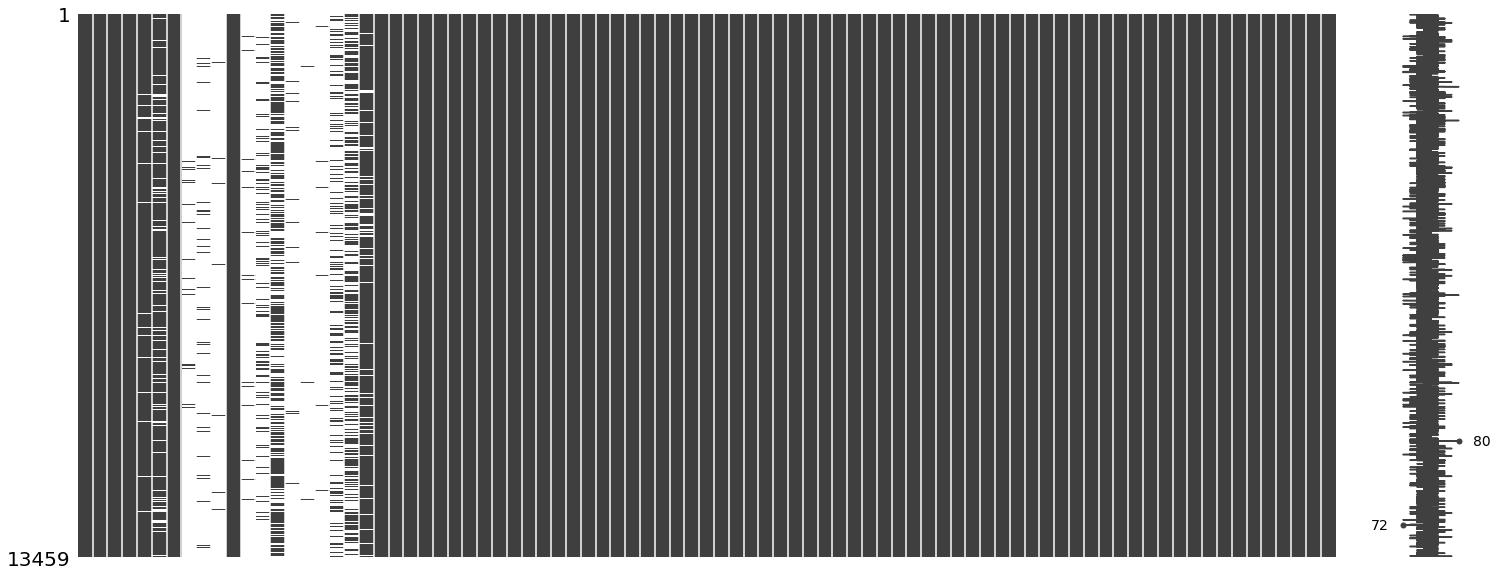

In [9]:
msno.matrix(suspect)

Read more about the iterative imputer (inspired of R's MICE)
https://scikit-learn.org/stable/modules/impute.html#iterative-imputer

In [10]:
column_names = suspect.columns.to_list()

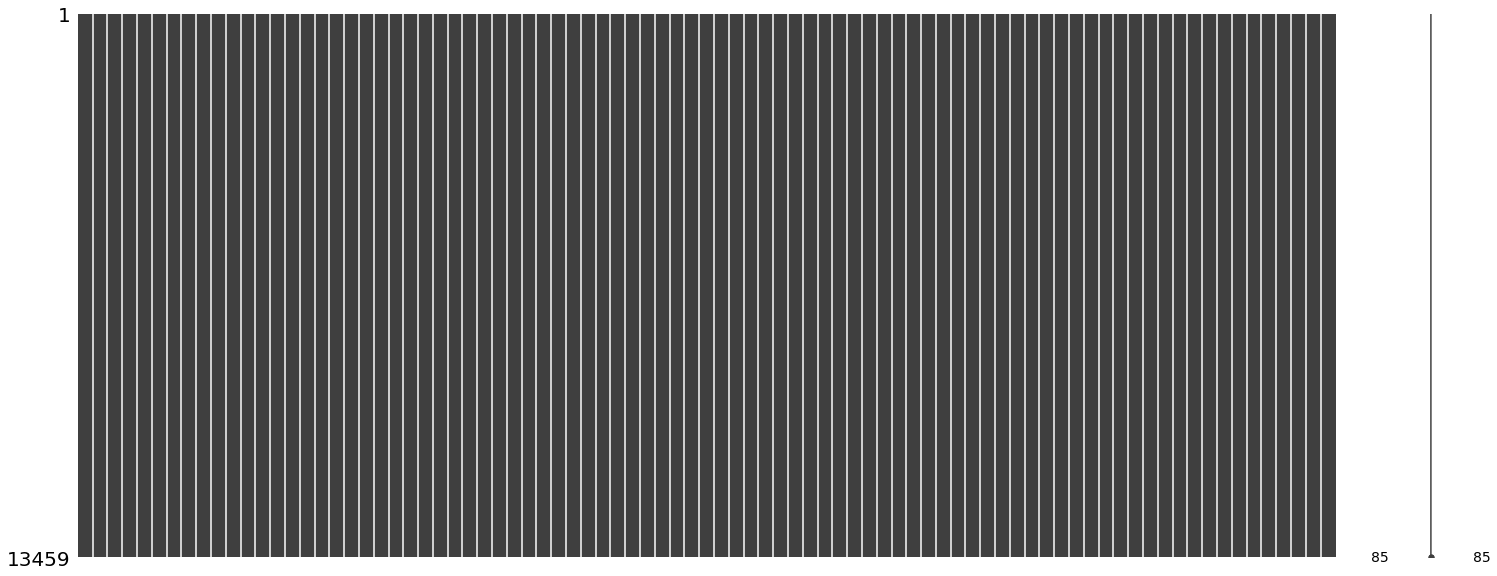

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 10, random_state = 0)
imp.fit(suspect)

#impute
suspect_ITER = pd.DataFrame(np.round(imp.transform(suspect)), columns = column_names)

# drop any remaining rows
suspect_ITER = suspect_ITER.dropna(axis = 0)

#visaulize
msno.matrix(suspect_ITER)

# Updating Summary Table
summary_table['suspect'][1] = len(suspect_ITER)

In [12]:
summary_table['suspect'][2] = summary_table['suspect'][0] - summary_table['suspect'][1]
summary_table

,suspect,officer,location
Original Number of Rows,13459,13459,13459
Post-Clean,13459,NaN,NaN
Difference/Rows Dropped,0,NaN,NaN


## 2. officer

### Cleaning clerical errors and correcting data types

In [13]:
# Cleaning the Shield, ID, and Verbal Dummies
officer['SHIELD_IDENTIFIES_OFFICER_FLAG'] = [1 if i == 'S' else 0 for i in officer['SHIELD_IDENTIFIES_OFFICER_FLAG']]
officer['VERBAL_IDENTIFIES_OFFICER_FLAG'] = [1 if i == 'V' else 0 for i in officer['VERBAL_IDENTIFIES_OFFICER_FLAG']]
officer['ID_CARD_IDENTIFIES_OFFICER_FLAG'] = [1 if i == 'I' else 0 for i in officer['ID_CARD_IDENTIFIES_OFFICER_FLAG']]

# Converting the Y/N symbols to 1/0 accordingly
officer.replace({"Y": 1, "N" : 0}, inplace = True)

#Turning clerical errors such as typing "(" and "(null)" into a NaN 
officer.replace({'(null)': np.nan, '': np.nan, ' ': np.nan} ,inplace = True)

#Filling in any remaining missing values with na for visualization
officer.fillna(np.nan, inplace = True)

officer.head()

/Users/winsontruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/winsontruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/winsontruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,STOP_ID_ANONY,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG
0,1,POM,1,SGT,1,1,0,0,0
1,2,POM,1,SGT,1,0,0,1,1
2,3,POM,1,SGT,1,1,0,0,0
3,4,POM,1,SGT,1,1,0,0,0
4,5,POM,1,SGT,1,0,0,1,1


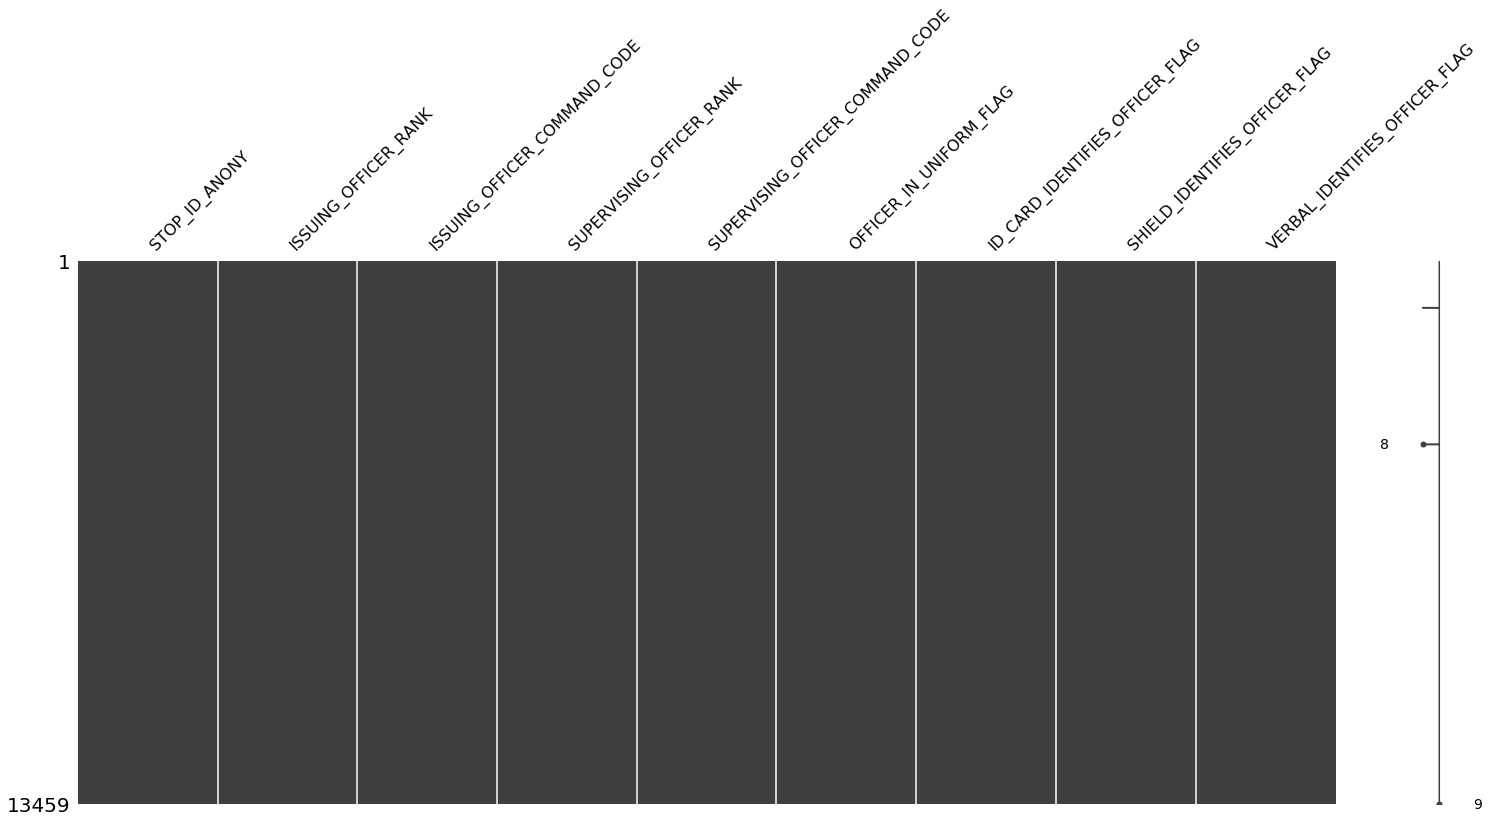

In [14]:
# Visualize
msno.matrix(officer)

Great! Overall the officers are well defined.

Becuase there are so many features it might be easier to group the shield, verbal, and ID card identifiers to create a column that denotes if the individual knew the person was an officer. If there are any other missing rows that my eyes can't detect from the visualization above, I'm okay with dropping them as they are <1% of our total data.

In [15]:
# Interacting to create a simpler column
officer['IDENTIFIED_AS_COP'] = officer['ID_CARD_IDENTIFIES_OFFICER_FLAG']* officer['VERBAL_IDENTIFIES_OFFICER_FLAG'] * officer['SHIELD_IDENTIFIES_OFFICER_FLAG']

/Users/winsontruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
summary_table['officer'][1] = len(officer)
summary_table['officer'][2] = summary_table['officer'][0] - summary_table['officer'][1]
summary_table

,suspect,officer,location
Original Number of Rows,13459,13459,13459
Post-Clean,13459,13459,NaN
Difference/Rows Dropped,0,0,NaN


## 3. location
Poor documentation is a challenge. The 'STOP_LOCATION_X' and 'STOP_LOCATION_Y' are not latitude, longitude nor is it Universal Time Mercader. Possible meanings:
* precinct and sector identifiers within NY
* State plane coordinate system

### Cleaning clerical errors and correcting data types

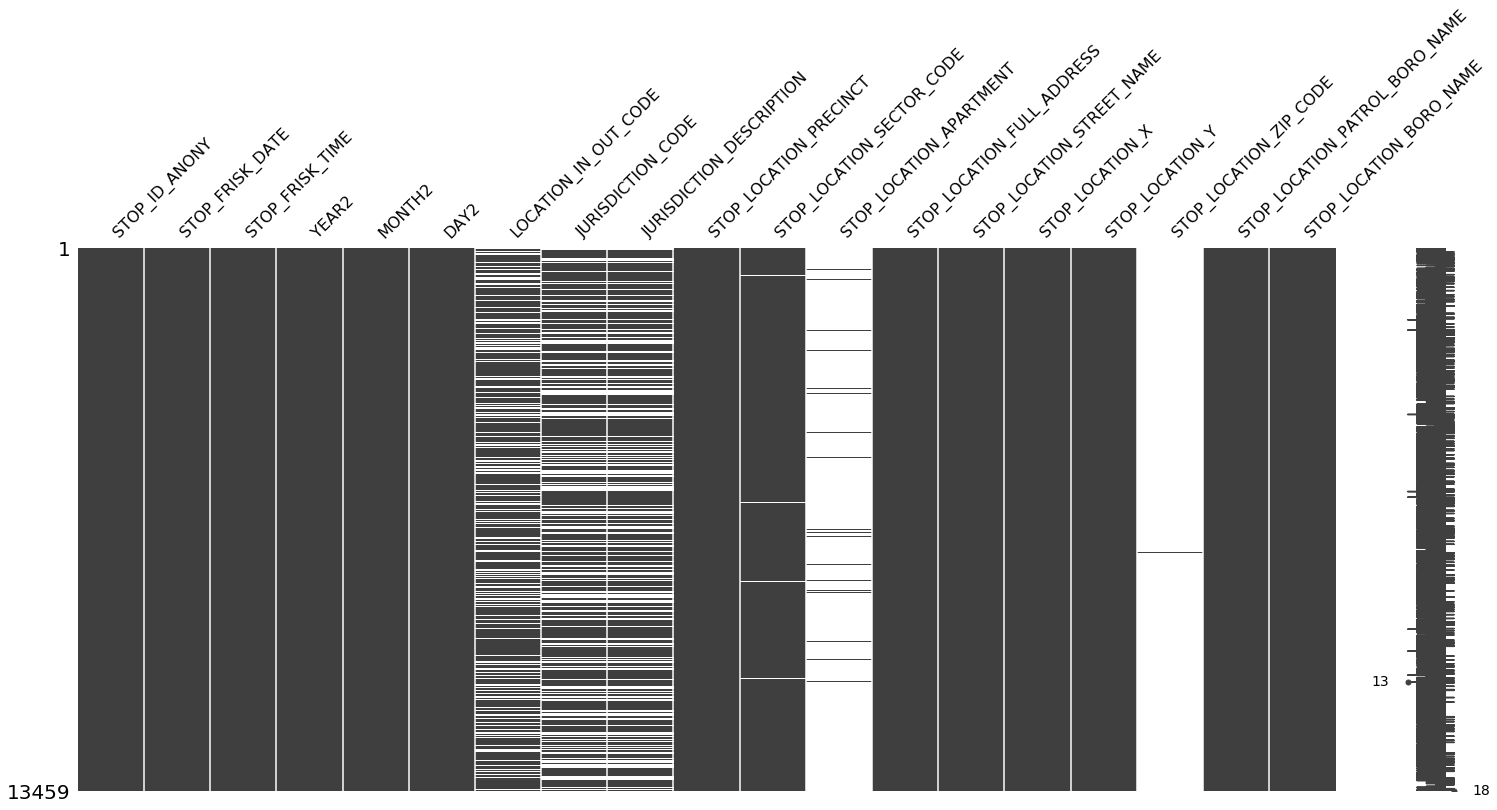

In [17]:
#Turning clerical errors such as typing "(" and "(null)" into a NaN 
location.replace({'(null)': np.nan, "(": np.nan, '': np.nan, ' ': np.nan} ,inplace = True)

#Filling in any remaining missing values with na for visualization
location.fillna(np.nan, inplace = True)

msno.matrix(location)

### Alright. Low-haning fruit first.

I'm going to drop apartment as that level of granularity is both challenging to clean/impute and also is highly sensitive information that should never be put in the database in the first place.

In [18]:
location = location.drop('STOP_LOCATION_APARTMENT', axis = 1)

#### Now let's use the handy categorical imputation function we made earlier

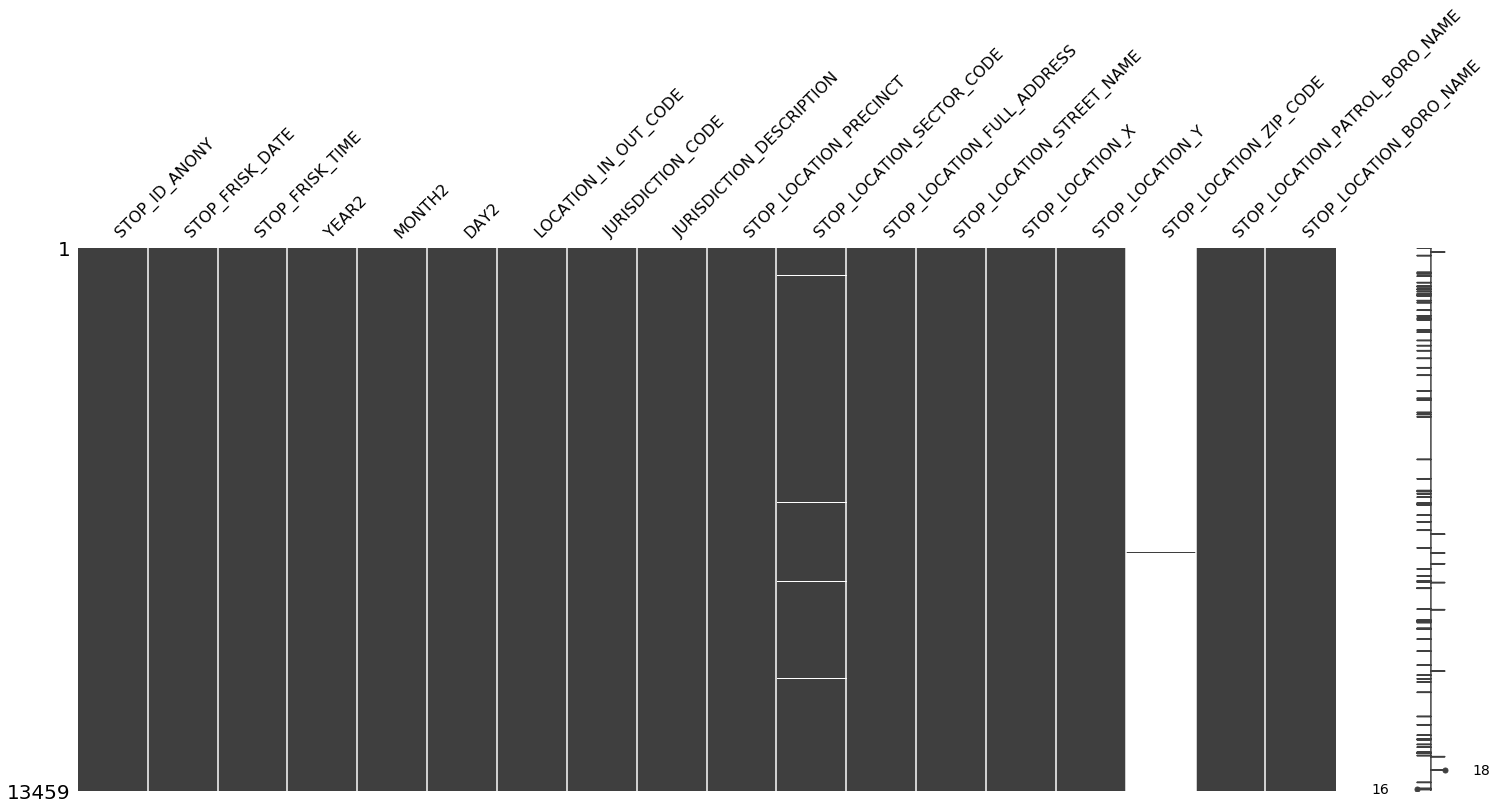

In [19]:
categorical_impute(location, ['LOCATION_IN_OUT_CODE', 'JURISDICTION_DESCRIPTION',
                             'JURISDICTION_DESCRIPTION', 'JURISDICTION_CODE'])
msno.matrix(location)

For now it seems as if spatial analysis viz zipcode is not possible and we will have to settle for using boroughs.

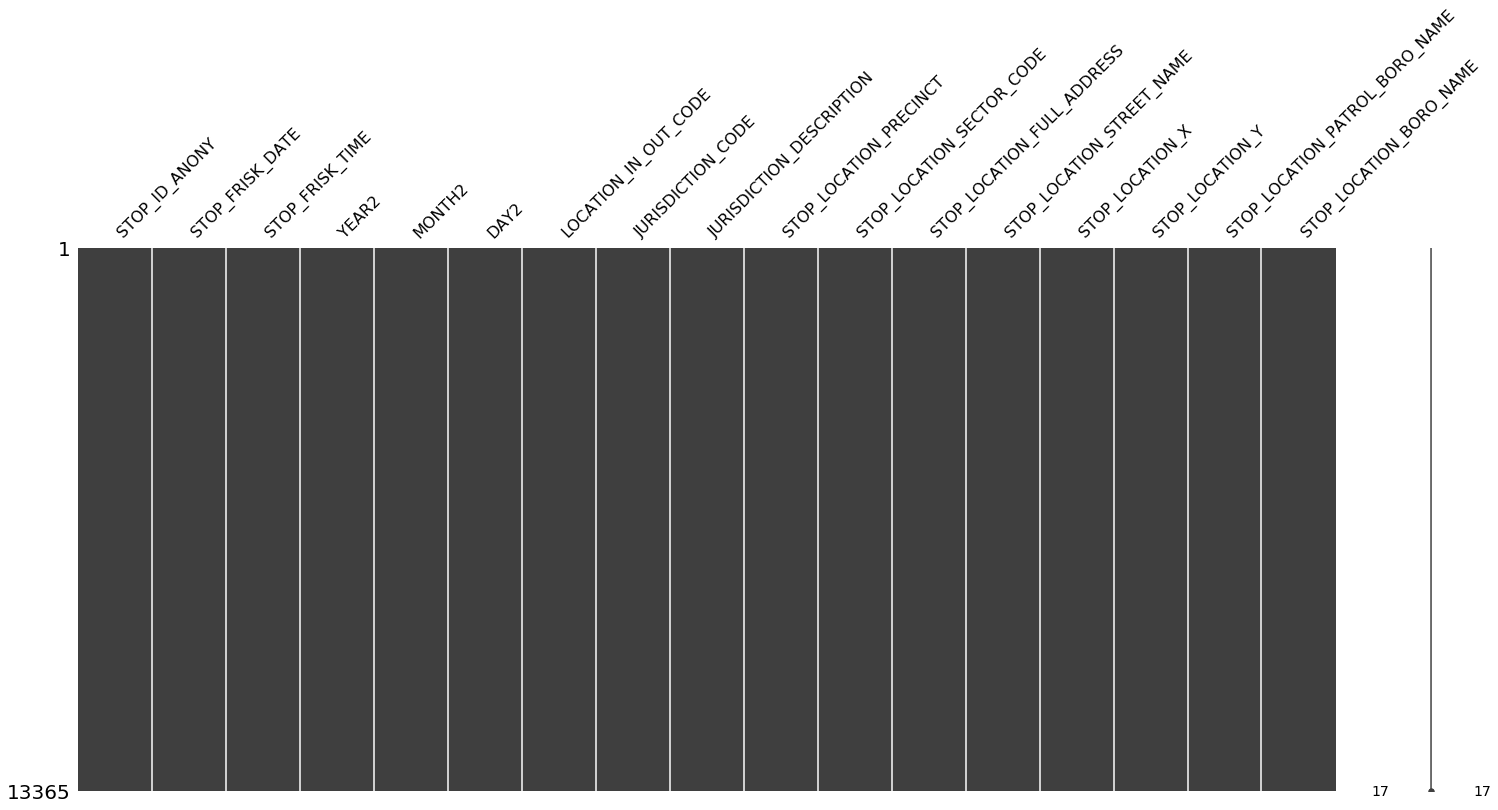

In [20]:
location = location.drop('STOP_LOCATION_ZIP_CODE', axis = 1)
location = location.dropna(axis = 0)
msno.matrix(location)

In [21]:
summary_table['location'][1] = len(location)
summary_table['location'][2] = summary_table['location'][0] - summary_table['location'][1]

summary_table

,suspect,officer,location
Original Number of Rows,13459,13459,13459
Post-Clean,13459,13459,13365
Difference/Rows Dropped,0,0,94


Great! After imputation we only had to drop 94 rows.

## Reaggregation

In [22]:
suspect_ITER.shape, officer.shape

((13459, 85), (13459, 10))

In [23]:
# Merge back together
a = suspect_ITER.merge(officer, how = 'inner', on = 'STOP_ID_ANONY')

# Dropping an extra 2 rows for the sake of a fully defined matrix
final = a.merge(location, how = 'inner', on = 'STOP_ID_ANONY').dropna(axis = 0)

print(f"Overall, at an original starting point of {len(raw)} rows, we are left with {final.shape[0]} rows")

Overall, at an original starting point of 13459 rows, we are left with 13363 rows


In [24]:
final.to_csv('../data/cleaned_one_hot.csv')

In [25]:
raw.shape, final.shape

((13459, 83), (13363, 110))

## Renaming Columns and Recombining the dummy columns

In [26]:
final.columns = map(str.lower, final.columns)

In [27]:
race_rename = { "suspect_race_description_american indian/alaskan n":"Indian/Alaskan Native",
               "suspect_race_description_asian / pacific islander":"Asian / Pacific Islander",
               "suspect_race_description_black":"Black",
               "suspect_race_description_black hispanic":"Black Hispanic",
               "suspect_race_description_white":"White",
               "suspect_race_description_white hispanic":"White Hispanic"}

haircolor_rename = { "suspect_hair_color_bld":"Bald",
                    "suspect_hair_color_blk":"Black",
                    "suspect_hair_color_bln":"Blonde",
                    "suspect_hair_color_bro":"Brown",
                    "suspect_hair_color_grn":"Green",
                    "suspect_hair_color_gry":"Gray",
                   "suspect_hair_color_org": "Orange",
                   "suspect_hair_color_ple": "Ple",
                   "suspect_hair_color_pnk": "Pink",
                   "suspect_hair_color_red": "Red",
                   "suspect_hair_color_sdy": "Sdy",
                   "suspect_hair_color_whi": "White",
                   "suspect_hair_color_xxx": "Other1",
                   "suspect_hair_color_zzz": "Other2"}

buildtype_rename = {"suspect_body_build_type_hea": "Heavy",
                   "suspect_body_build_type_med": "Medium",
                   "suspect_body_build_type_thn": "Thin",
                   "suspect_body_build_type_u": "Underweight",
                   "suspect_body_build_type_xxx": "Other3"}

eyecolor_rename = {"suspect_eye_color_blk": "Black",
                   'suspect_eye_color_blu':"Blue",
                   'suspect_eye_color_bro':"Brown",
                   'suspect_eye_color_grn':"Green",
                   'suspect_eye_color_gry':"Gray",
                   'suspect_eye_color_haz':"Hazel",
                   'suspect_eye_color_mul':"Multicolor",
                   'suspect_eye_color_oth': "Other4",
                   'suspect_eye_color_pnk': "Other5",
                   'suspect_eye_color_zzz': "Other6",
                  }

suspected_crime_rename = {'suspected_crime_description_assault':'Assult',
 'suspected_crime_description_auto strippig':'Auto Stripping',
 'suspected_crime_description_burglary':'Burglary',
 'suspected_crime_description_cpsp':'CPSP',
 'suspected_crime_description_cpw':'CPW',
 'suspected_crime_description_criminal mischief': 'Criminal Mischief',
 'suspected_crime_description_criminal possession of controlled substance':'Possesion of a Controlled Substance',
 'suspected_crime_description_criminal possession of forged instrument':'Possession of a Forged Instrument',
 'suspected_crime_description_criminal possession of marihuana': 'Possession of Marijuana',
 'suspected_crime_description_criminal sale of controlled substance':'Sale of a Conrtolled Substance',
 'suspected_crime_description_criminal sale of marihuana': 'Sale of Marijuana',
 'suspected_crime_description_criminal trespass': 'Criminal Tresspass',
 'suspected_crime_description_forcible touching': 'Forcible Touching',
 'suspected_crime_description_grand larceny':'Grand Larceny',
 'suspected_crime_description_grand larceny auto': 'Grand Larceny Auto',
 'suspected_crime_description_making graffiti': 'Making Graffiti',
 'suspected_crime_description_menacing': 'Menacing',
 'suspected_crime_description_murder': 'Murder',
 'suspected_crime_description_other': 'Other7',
 'suspected_crime_description_petit larceny': 'Petit Larceny',
 'suspected_crime_description_prostitution': 'Prostitution',
 'suspected_crime_description_rape': 'Rape',
 'suspected_crime_description_reckless endangerment': 'Reckless Endangerment',
 'suspected_crime_description_robbery': 'Robbery',
 'suspected_crime_description_terrorism': 'Terrorism',
 'suspected_crime_description_theft of services': 'Theft of Services',
 'suspected_crime_description_unauthorized use of a vehicle': 'Unauthorized Use of a Vehicle'}

In [28]:
final.rename(race_rename, axis = 1, inplace = True)
final.rename(haircolor_rename, axis = 1, inplace = True)
final.rename(buildtype_rename, axis = 1, inplace = True)
final.rename(eyecolor_rename, axis = 1, inplace = True)
final.rename(suspected_crime_rename, axis = 1, inplace = True)

In [29]:
race = final[['Indian/Alaskan Native','Asian / Pacific Islander','Black',
              'Black Hispanic','White','White Hispanic']].idxmax(axis=1)



hair_color = final[['Bald','Black','Blonde','Brown',
                    'Green','Gray','Orange','Ple','Pink','Red','Sdy','White',
                    'Other1','Other2']].idxmax(axis = 1)

#replacing various other as a generic 'other'
hair_color = hair_color.replace({"Other1": "Other", "Other2":"Other"})




build_type = final[['Heavy','Medium','Thin','Underweight','Other3']].idxmax(axis = 1)
#replacing various other as a generic 'other'
build_type = build_type.replace({"Other3": "Other"})



eye_color = final[['Black','Blue','Brown','Green','Gray','Hazel','Multicolor','Other4','Other5','Other6']].idxmax(axis = 1)
#replacing various other as a generic 'other'
eye_color = eye_color.replace({"Other4": "Other","Other5": "Other","Other6": "Other"})



suspected_crime = final[[ 'Assult','Auto Stripping','Burglary',
 'CPSP','CPW','Criminal Mischief', 'Possesion of a Controlled Substance',
 'Possession of a Forged Instrument', 'Possession of Marijuana', 'Sale of a Conrtolled Substance',
 'Sale of Marijuana','Criminal Tresspass','Forcible Touching','Grand Larceny','Grand Larceny Auto',
 'Making Graffiti','Menacing','Murder','Other7', 'Petit Larceny','Prostitution','Rape', 'Reckless Endangerment',
 'Robbery','Terrorism','Theft of Services', 'Unauthorized Use of a Vehicle']].idxmax(axis = 1)

#replacing various other as a generic 'other'
suspected_crime = suspected_crime.replace({"Other7": "Other"})

In [30]:
final_drop = final.drop(['Indian/Alaskan Native','Asian / Pacific Islander','Black',
              'Black Hispanic','White','White Hispanic','Bald','Black','Blonde','Brown',
                    'Green','Gray','Orange','Ple','Pink','Red','Sdy','White',
                    'Other1','Other2','Heavy','Medium','Thin','Underweight','Other3',
                    'Black','Blue','Brown','Green','Gray','Hazel','Multicolor','Other4','Other5','Other6',
                    'Assult','Auto Stripping','Burglary', 'CPSP','CPW','Criminal Mischief', 'Possesion of a Controlled Substance',
 'Possession of a Forged Instrument', 'Possession of Marijuana', 'Sale of a Conrtolled Substance',
 'Sale of Marijuana','Criminal Tresspass','Forcible Touching','Grand Larceny','Grand Larceny Auto',
 'Making Graffiti','Menacing','Murder','Other7', 'Petit Larceny','Prostitution','Rape', 'Reckless Endangerment',
 'Robbery','Terrorism','Theft of Services', 'Unauthorized Use of a Vehicle'], axis = 1)


final2 = pd.concat([final_drop, race, hair_color, build_type, eye_color, suspected_crime], axis =1)

In [31]:
final2 = final2.rename({0:'race', 1: 'hair_color', 2: 'build_type', 3: 'eye_color', 4: 'suspected.crime'}, axis = 1)
final2.head()

,stop_id_anony,suspect_arrested_flag,frisked_flag,searched_flag,ask_for_consent_flg,consent_given_flg,other_contraband_flag,firearm_flag,knife_cutter_flag,other_weapon_flag,...,stop_location_street_name,stop_location_x,stop_location_y,stop_location_patrol_boro_name,stop_location_boro_name,race,hair_color,build_type,eye_color,suspected.crime
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,VESEY STREET,979667,199737,PBMS,MANHATTAN,Black,Black,Heavy,Black,Petit Larceny
1,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,WHITE STREET,982650,201326,PBMS,MANHATTAN,Black,Black,Medium,Black,Grand Larceny
2,3.0,1.0,0.0,0.0,0.0,-0.0,0.0,1.0,1.0,1.0,...,SPRING STREET,984063,203033,PBMS,MANHATTAN,Black,Black,Heavy,Black,Petit Larceny
3,5.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,THOMPSON STREET,983100,202705,PBMS,MANHATTAN,Black,Black,Thin,Black,Assult
4,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,STONE STREET,980765,195773,PBMS,MANHATTAN,Black,Black,Medium,Black,Burglary


In [32]:
final2.to_csv('../data/cleaned_reagg.csv')

# Appendix

The following code was checking the similarity in descriptions between 2018 data and 2019 data. Overall there are few matches, it would take manual review to join the columns to be expand more than one year. For now, this  will be "put in the fridge".

In [33]:
# url2018 = 'https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2018.xlsx'
# raw2018 = pd.read_excel(url2018)

# test = pd.DataFrame(columns = [2019, 2018, 'Boolean'])
# test[2019] = raw.columns.to_list()
# test[2018] = raw2018.columns.to_list()

# [i for i, j in zip(test[2019], test[2018]) if i == j]